# Risk Mapping Introductory Notebook

This example shows methods to process and visualize spatial aggregates of fire index and human built up areas. We will use data from the CA Fire and Rescue Assessment program for fire risk, county and city administrative regions datasets and the building construction change detection analytic reults to overlay human activity in areas of high fire risk

In [370]:
import requests
import os
import json
import pandas as pd
import geopandas as gpd
from h3 import h3
from pprint import pprint
import csv
from math import sqrt

import folium
import webbrowser
from folium import Map
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse



California Fires related data sources are aggregated at:
https://libguides.csun.edu/gis/california

CAL FIRE Fire and Resource Assessment Program (FRAP)
https://frap.fire.ca.gov/media/3180/assessment2017.pdf
https://frap.fire.ca.gov/mapping/gis-data/

FRAP gives us a statewide GIS layer in raster format of fire threat, which combines expected fire frequency with potential fire behavior to create 4 threat classes (v14_2 at fthrt14_2.zip). Converted this data from arcGIS data tables (gdbtables) to GEOTIFF and then used the QGIS zonal stats processing toolbox to get to the firethreat data set as GeoJSON.

Identifying data locations relative to the notebook location. 

In [352]:
SUB_ID_CA = '0163608e-0afb-477e-a500-3a87819351a1'
SUBSCRIPTION_ID = SUB_ID_CA

root_folder = './data/'
fire_threat_geojson = root_folder + 'CA-county_boundaries_firethreat.geojson'
subscription_geojson = root_folder + 'collection_0163608e-0afb-477e-a500-3a87819351a1.geojson'
city_geojson = root_folder + 'santa_clarita_city.geojson'

## Data Load and Prep

We load county with fire threat into polgyons into a geopandas dataframe. The risk data converts the 6 integer classes [0, 5] to the range [0.0, 128.0] after computing zonal stats

In [353]:
with open(fire_threat_geojson,  encoding = "ISO-8859-1") as f:
    study_area = json.load(f)
gdf = gpd.GeoDataFrame.from_features(study_area["features"])
gdf.shape

gdf.rename(columns={'_mean':'AV_FIRE_THREAT'}, inplace=True)
gdf['AV_FIRE_THREAT'] = gdf['AV_FIRE_THREAT'].apply(lambda x: x/128.0)
gdf.rename(columns={'_max':'MAX_FIRE_THREAT'}, inplace=True)
gdf['MAX_FIRE_THREAT'] = gdf['MAX_FIRE_THREAT'].apply(lambda x: x/128.0)
gdf.rename(columns={'_range':'RANGE_FIRE_THREAT'}, inplace=True)
gdf['RANGE_FIRE_THREAT'] = gdf['RANGE_FIRE_THREAT'].apply(lambda x: x/128.0)
gdf.rename(columns={'_variance':'STDDEV_FIRE_THREAT'}, inplace=True)
gdf['STDDEV_FIRE_THREAT'] = gdf['STDDEV_FIRE_THREAT'].apply(lambda x: sqrt(x)/128.0)

Let's take a look at what columns exits in this dataframe

In [367]:
gdf.columns

Index(['geometry', 'GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA',
       '_count', '_sum', 'AV_FIRE_THREAT', 'MAX_FIRE_THREAT',
       'RANGE_FIRE_THREAT', 'STDDEV_FIRE_THREAT'],
      dtype='object')

## State Level Risk Profile

We now want to see the fire risk profile looks like across the State of CA and where the hotspots of fire risk are. Since we did the zonal stats based on county boundaries, we will have aggregated risk granularity at county level. We are going to use folium for spatial visualization. We are going to create two switchable folium layers, one for average risk and risk variability at one sigma so that we can have a holistic view into spatial fire risk data. One of the limitations of folium in a jupyter notebook is that you might get an IOPub data rate error if you try to load up too many geometries. You can change your IOPub data rate, or you can simply load up less data by simplifying the geometries. 

In [369]:
gdf['geometry'] = gdf['geometry'].simplify(0.01, preserve_topology=False)

centroid=gdf.geometry.centroid[1]

m = folium.Map([centroid.y, centroid.x], zoom_start=5, tiles='cartodbpositron')

df=pd.DataFrame(gdf.loc[:,['AV_FIRE_THREAT']])

from branca.colormap import linear
colormap = linear.YlOrRd_09.scale(df.AV_FIRE_THREAT.min(),df.AV_FIRE_THREAT.max())

key = [str(index) for index, item in df.iterrows()]
a = [df[key].values for key in df.keys()]
values = [colormap(x) for x in list(a[0])]
color_dict = dict(zip(key, values))

folium.GeoJson(
    gdf.to_json(),
    name="Average Fire Risk",
    style_function=lambda feature: {
        'fillColor': color_dict[feature['id']],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.9,
    }
).add_to(m)

colormap.caption = 'Average Risk'
colormap.add_to(m)

df=pd.DataFrame(gdf.loc[:,['STDDEV_FIRE_THREAT']])

from branca.colormap import linear
colormap = linear.RdPu_09.scale(df.STDDEV_FIRE_THREAT.min(),df.STDDEV_FIRE_THREAT.max())

key = [str(index) for index, item in df.iterrows()]
a = [df[key].values for key in df.keys()]
values = [colormap(x) for x in list(a[0])]
color_dict_dev = dict(zip(key, values))

folium.GeoJson(
    gdf.to_json(),
    name="Risk Variability",
    style_function=lambda feature: {
        'fillColor': color_dict_dev[feature['id']],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.9,
    }
).add_to(m)

colormap.caption = 'Risk Variability'
colormap.add_to(m)

folium.LayerControl(autoZIndex=False, collapsed=False).add_to(m)

m

## Zoning in on Los Angeles County

We notice that zones of high risk are also prone to high spatial varaibility. Areas near Central Valley have medium risk but also high variability owing to a predominantly grassland ecoregion. More at: https://www.worldwildlife.org/ecoregions/na0801

Let's now zone in our exploration and look more closely at the region near Castaic near the city of Santa Clarita in Los Angeles County, where serious fires broke out on Oct 10 affecting over 9000 acres of land. More on 2019 CA fires at: https://en.wikipedia.org/wiki/2019_California_wildfires

We will filter the the buildling construction change analytic results from March-May 2019 based on the geometries  using a spatial join on the county geometry after matching geometric projections/CRS. Since we are mainly interested in significant built up areas, we will filter the construction change by 1600 sq meters (approximating a 40mx40m building)

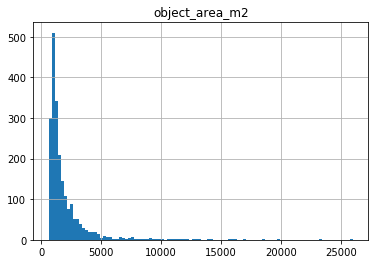

In [371]:
gdf_la = gdf.loc[gdf['NAME']=='Los Angeles']

gdf_builtup = gpd.read_file(subscription_geojson)

gdf_la.crs = {'init': 'epsg:4326'}

gdf_builtup_la = gpd.sjoin(gdf_builtup, gdf_la, how="inner", op='intersects')

gdf_builtup_la.hist(column='object_area_m2', bins=100)

gdf_builtup_la_filtered = gdf_builtup_la[gdf_builtup_la['object_area_m2'].between(1600.0, gdf_builtup_la['object_area_m2'].max())]

We want to load up region/city boundaries within Los Angeles County. We use the boundaries data set from https://hub.arcgis.com/datasets/7b0998f4e2ea42bda0068afc8eeaf904_19/data, convert the shape file to GeoJSON and then update it with zonal statistics from QGIS. We can now load the data to a geopandas dataframe

In [378]:
gdf_cities = gpd.read_file("./data/LA_County_City_Boundaries.geojson")

In [379]:
print(gdf_cities.columns)
print(gdf_cities.shape)
print(gdf_builtup_la.shape)

Index(['OBJECTID', 'CITY', 'CITY_ID', 'CITY_TYPE', 'CITY_NAME', 'CITY_LABEL',
       'COLOR_CODE', 'ABBR', 'CITY_NO', 'DESCRIPTN', 'URL', 'PHONE',
       'OF_AREA_SM', 'FEAT_TYPE', 'COMMENT', 'COLOR_EGIS', 'POPULATION',
       'ShapeSTAre', 'ShapeSTLen', '_count', '_sum', '_mean', '_stdev', '_max',
       'geometry'],
      dtype='object')
(318, 25)
(2165, 21)


We would now like to learn where we say built up area in Los Angeles based on cities/regions boundaries. We do a second spatial join to secure an augmented built up dataset 

In [381]:
# gdf_builtup_la.drop('index_right', axis=1, inplace=True)
gdf_builtup_la_cities = gpd.sjoin(gdf_builtup_la, gdf_cities, how="inner", op='intersects')
print(gdf_builtup_la_cities.columns)

Index(['id', 'label', 'object_area_m2', 'observed', 'source_last_acquired',
       'source_mosaic', 'source_mosaic_name', 'source_quad_id', 'geometry',
       'GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA',
       '_count_left', '_sum_left', 'AV_FIRE_THREAT', 'MAX_FIRE_THREAT',
       'RANGE_FIRE_THREAT', 'STDDEV_FIRE_THREAT', 'index_right', 'OBJECTID',
       'CITY', 'CITY_ID', 'CITY_TYPE', 'CITY_NAME', 'CITY_LABEL', 'COLOR_CODE',
       'ABBR', 'CITY_NO', 'DESCRIPTN', 'URL', 'PHONE', 'OF_AREA_SM',
       'FEAT_TYPE', 'COMMENT', 'COLOR_EGIS', 'POPULATION', 'ShapeSTAre',
       'ShapeSTLen', '_count_right', '_sum_right', '_mean', '_stdev', '_max'],
      dtype='object')


At this point we can even filter based on individual cities to zone in on specific districts but we are not going to do that right now. Here is just an illustrative example. Notice that we now have a bunch of columns, the result of multiple inner spatial joins leading to additive metadata

In [382]:
#plot threat indicators by county
gdf_builtup_la_cities.loc[gdf_builtup_la_cities['CITY_NAME'] == 'Santa Clarita'].head(5)

,id,label,object_area_m2,observed,source_last_acquired,source_mosaic,source_mosaic_name,source_quad_id,geometry,GEO_ID,...,COMMENT,COLOR_EGIS,POPULATION,ShapeSTAre,ShapeSTLen,_count_right,_sum_right,_mean,_stdev,_max
2061,617777b1-c4e8-408e-b590-1d2ffbe25be4,building,699.991808,2019-06-01T00:00:00,2019-07-01T00:00:00,None,global_monthly_2019_06_mosaic,349-1232,"POLYGON ((-118.51330 34.35336, -118.51343 34.3...",0500000US06037,...,None,"Pink - RGB 255,190,232",None,1.973159e+09,352383.193058,203646.0,14445547.0,70.934597,61.945627,128.0
2062,650417f6-864b-4e42-9cb3-d351bc20a6bc,building,1081.094544,2019-06-01T00:00:00,2019-07-01T00:00:00,None,global_monthly_2019_06_mosaic,349-1232,"POLYGON ((-118.52943 34.35360, -118.52952 34.3...",0500000US06037,...,None,"Pink - RGB 255,190,232",None,1.973159e+09,352383.193058,203646.0,14445547.0,70.934597,61.945627,128.0
2063,81d90367-39c4-4d69-b586-5270c7e586ad,building,18455.842959,2019-06-01T00:00:00,2019-07-01T00:00:00,None,global_monthly_2019_06_mosaic,349-1232,"POLYGON ((-118.51042 34.35552, -118.51051 34.3...",0500000US06037,...,None,"Pink - RGB 255,190,232",None,1.973159e+09,352383.193058,203646.0,14445547.0,70.934597,61.945627,128.0
2064,aae346f8-2e5e-42ad-a389-aa9b7d1da61f,building,5350.523101,2019-06-01T00:00:00,2019-07-01T00:00:00,None,global_monthly_2019_06_mosaic,349-1232,"POLYGON ((-118.50961 34.35786, -118.50974 34.3...",0500000US06037,...,None,"Pink - RGB 255,190,232",None,1.973159e+09,352383.193058,203646.0,14445547.0,70.934597,61.945627,128.0
2065,f186a713-5033-4998-b1ef-8d5d85a36a60,building,11183.056707,2019-06-01T00:00:00,2019-07-01T00:00:00,None,global_monthly_2019_06_mosaic,349-1232,"POLYGON ((-118.51124 34.35874, -118.51145 34.3...",0500000US06037,...,None,"Pink - RGB 255,190,232",None,1.973159e+09,352383.193058,203646.0,14445547.0,70.934597,61.945627,128.0


Looking at the distribution of average risk across the different cities in Los Angeles county, we see a bimodal distribution with a few cities like West Hollywood having a very low risk and few like Santa Clarita and Palos Verdes having a very high risk index.

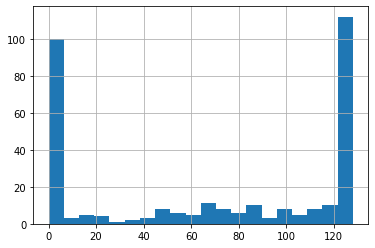

In [387]:
gdf_cities['_mean'].hist(bins=20)

Here is one representative data point, from a region in South Pasadena.

In [389]:
gdf_cities.columns
gdf_cities.iloc[100]

OBJECTID                                                  44753
CITY                                                       None
CITY_ID                                                    None
CITY_TYPE                                                  City
CITY_NAME                                        South Pasadena
CITY_LABEL                                       South Pasadena
COLOR_CODE                                                    4
ABBR                                                       None
CITY_NO                                                      80
DESCRIPTN                                                  SPAS
URL                                 www.ci.south-pasadena.ca.us
PHONE                                                6264037200
OF_AREA_SM                                                3.468
FEAT_TYPE                                                  Land
COMMENT                                                    None
COLOR_EGIS                              

We also need to specify our colors, and I am doing this manually using branca linear color palettes  following brewer colors (https://github.com/ajdawson/colormaps/tree/master/lib/colormaps/palette/brewer/sequential) and the style attribute of our GeoDataFrame. The 'style' column is special, because folium will look for a column named 'style' to provide the the style attributes (similar to the 'geography' column). By default, the geometries that you get from the Census bureau are very detailed. This can cause problems loading in Chrome, so I use the geopandas simplify function to reduce the complexity of the geometries while still preserving the shape. Setting the tolerance takes a little trial and error, and in this particular example, I found that 0.001 worked well (a higher tolerance produces simpler geometry). By setting preserve_topology to False we can speed up the operation, and produce simpler geometries but could lead to gaps in between the polygons.

In [401]:
gdf = gpd.read_file("./data/LA_County_City_Boundaries.geojson")
gdf['geometry'] = gdf['geometry'].simplify(0.001, preserve_topology=False)

centroid = gdf.geometry.centroid[1]
m = folium.Map([centroid.y, centroid.x], zoom_start=8, tiles='cartodbpositron')

df=pd.DataFrame(gdf.loc[:,['_mean']])

from branca.colormap import linear

colormap = linear.OrRd_09.scale(df._mean.min(), df._mean.max())

key = [str(index) for index, item in df.iterrows()]
a = [df[key].values for key in df.keys()]
values = [colormap(x) for x in list(a[0])]
color_dict = dict(zip(key, values))

folium.GeoJson(
    gdf.to_json(),
    style_function=lambda feature: {
        'fillColor': color_dict[feature['id']],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.9,
    }
).add_to(m)

colormap.caption = 'Average Risk'
colormap.add_to(m)

m

In [393]:
# Optionally for tooltip but not looking into this now
#
# for i in range(len(gdf)):
#     gs = folium.GeoJson(gdf.iloc[i:i+1])
#     label = '{} : {} tolerance {} max'.format(gdf['CITY_NAME'][i], round(gdf['_stdev'][i]/128.0), round(gdf['_max'][i]/128.0))
#     folium.Popup(label).add_to(gs)
#     gs.add_to(m)
# m.save('./data/GeoJSON_and_choropleth_10.html')
# m

Getting to number of built up assets within each city/administrative region within the county

In [402]:
vc = gdf_builtup_la_cities['CITY_NAME'].value_counts().to_dict()
gdf_cities['built_count'] = gdf_cities.apply(lambda x: 0, axis=1)

for index, row in gdf_cities.iterrows():
    if row['CITY_NAME'] in list(vc.keys()):
        gdf_cities.loc[index, 'built_count'] = vc[row['CITY_NAME']]

gdf_cities.head(5)

,OBJECTID,CITY,CITY_ID,CITY_TYPE,CITY_NAME,CITY_LABEL,COLOR_CODE,ABBR,CITY_NO,DESCRIPTN,...,POPULATION,ShapeSTAre,ShapeSTLen,_count,_sum,_mean,_stdev,_max,geometry,built_count
0,44652,None,None,Unincorporated,Unincorporated,CO,1,None,0,UNINC,...,None,6.734394e+04,1137.278781,8.0,1024.0,128.000000,0.000000,128.0,"POLYGON ((-118.40090 34.09514, -118.40091 34.0...",272
1,44653,None,None,City,West Hollywood,West Hollywood,3,None,86,WD,...,None,5.283010e+07,57026.051152,5408.0,692224.0,128.000000,0.000000,128.0,"POLYGON ((-118.36817 34.09730, -118.36817 34.0...",0
2,44654,None,None,City,Alhambra,Alhambra,2,None,2,ALH,...,None,2.127653e+08,69046.929270,21956.0,1183244.0,53.891601,63.190322,128.0,"POLYGON ((-118.12191 34.10503, -118.12187 34.1...",7
3,44655,None,None,City,Beverly Hills,Beverly Hills,2,None,11,BVH,...,None,1.592846e+08,86932.175143,16443.0,1634299.0,99.391778,53.278354,128.0,"POLYGON ((-118.39585 34.09105, -118.39585 34.0...",1
4,44656,None,None,City,Bell,Bell,5,None,8,BELL,...,None,7.304297e+07,65459.614972,7544.0,682240.0,90.434783,58.285524,128.0,"POLYGON ((-118.15700 33.99141, -118.15703 33.9...",7


In [410]:
gdf = gdf_cities
gdf['geometry'] = gdf['geometry'].simplify(0.01, preserve_topology=False)
centroid=gdf.geometry.centroid[1]
m = folium.Map([centroid.y,centroid.x], zoom_start=8, tiles='cartodbpositron')

df=pd.DataFrame(gdf.loc[:,['built_count']])

from branca.colormap import linear
colormap = linear.Purples_09.scale(df.built_count.min(), df.built_count.max())

key = [str(index) for index, item in df.iterrows()]
a = [df[key].values for key in df.keys()]
values = [colormap(x) for x in list(a[0])]
color_dict = dict(zip(key, values))
    
folium.GeoJson(
    gdf.to_json(),
    style_function=lambda feature: {
        'fillColor': color_dict[feature['id']],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.9,
    }
).add_to(m)

colormap.caption = 'Built Up Count'
colormap.add_to(m)

m

In [404]:
df

,built_count
0,272
1,0
2,7
3,1
4,7
...,...
313,184
314,184
315,184
316,6


Now let's acccumulate built up area over cities/administrative regions and see what that looks like, this indicative of the aggregate net new human settlement and commerical activity

In [417]:
built_area = dict()
for index, row in gdf_builtup_la_cities.iterrows():
    if row['CITY_NAME'] in list(built_area.keys()):
        built_area[row['CITY_NAME']] += row['object_area_m2']
    else:
        built_area.update({row['CITY_NAME']:row['object_area_m2']})

gdf_cities['built_area'] = gdf_cities.apply(lambda x: 0, axis=1)

max_built_area = max(built_area.values())

for index, row in gdf_cities.iterrows():
    if row['CITY_NAME'] in list(built_area.keys()):
        gdf_cities.loc[index, 'built_area'] = built_area[row['CITY_NAME']]/max_built_area

In [418]:
max(built_area.values())

1294400.5057216682

In [419]:
gdf = gdf_cities
gdf['geometry'] = gdf['geometry'].simplify(0.01, preserve_topology=False)
centroid=gdf.geometry.centroid[1]
m = folium.Map([centroid.y,centroid.x], zoom_start=8, tiles='cartodbpositron')

df=pd.DataFrame(gdf.loc[:,['built_area']])

from branca.colormap import linear

colormap = linear.YlOrRd_09.scale(df.built_area.min(), df.built_area.max())

key = [str(index) for index, item in df.iterrows()]
a = [df[key].values for key in df.keys()]
values = [colormap(x) for x in list(a[0])]
color_dict = dict(zip(key, values))
    
folium.GeoJson(
    gdf.to_json(),
    style_function=lambda feature: {
        'fillColor': color_dict[feature['id']],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.9,
    }
).add_to(m)

colormap.caption = 'Built Up Density'
colormap.add_to(m)

m

## Bringing it together Human Activity in Fire Risk Areas

Getting a multi-layer folium plot with fire risk and built up area. The amount of built up area in Santa Clarita city, affected by the Castaic/SaddleRidge Fires in recent months is small relative to other areas.

In [413]:
gdf = gdf_cities
centroid=gdf.geometry.centroid[1]

#tiles='stamentoner'
m=folium.Map(location=[centroid.y, centroid.x], zoom_start=8, tiles='cartodbpositron')

df=pd.DataFrame(gdf.loc[:,['built_area']])
colormap = linear.Purples_09.scale(df.built_area.min(), df.built_area.max())

key = [str(index) for index, item in df.iterrows()]
a = [df[key].values for key in df.keys()]
values = [colormap(x) for x in list(a[0])]
color_dict = dict(zip(key, values))

folium.GeoJson(gdf.to_json(),
               name="Built Up Area",
               style_function=lambda x: {"weight":2, 'color':'black','fillColor':color_dict[x['id']], 'fillOpacity':0.7},
                ).add_to(m)

colormap.add_to(m)

df=pd.DataFrame(gdf.loc[:,['_mean']])
colormap = linear.YlOrRd_09.scale(df._mean.min(), df._mean.max())

key = [str(index) for index, item in df.iterrows()]
a = [df[key].values for key in df.keys()]
values = [colormap(x) for x in list(a[0])]
color_dict1 = dict(zip(key, values))
    
folium.GeoJson(gdf.to_json(),
               name='Average Risk',
               style_function=lambda x: {"weight":2, 'color':'black','fillColor':color_dict1[x['id']], 'fillOpacity':0.7},
              ).add_to(m)


colormap.add_to(m)

folium.LayerControl(autoZIndex=False, collapsed=False).add_to(m)

m